<center>
<h1>Assignment #2 for Clustering: Sessa Empirical Estimator (SEE)</h1>
by Christian Abay-abay & Thristan Jay Nakila
</center>

### Instructions
1. **Read the Journals about the Sessa Empirical Estimator**
   - *Refer to:* `/journals`
2. **Convert the R codes into Python**
   - **R codes:** `SEE.R`
   - **Python conversion:** `SEE.ipynb`
3. **Perform the Sessa Empirical Estimator**
   - Use either simulated data or real-world datasets of your choice.
   - Generate insights based on the estimator's results.
4. **Experiment with clustering algorithms**
   - The estimator uses K-means by default. Try substituting it with a different clustering algorithm to derive new insights.
   - *Note:* K-means has its disadvantages.
5. **Compare the results**
   - Analyze and compare the outcomes between the estimator using K-means and the one using your chosen clustering algorithm.
6. **Develop callable functions**
   - Create a callable function for each step.
   - Verify that these functions produce the same results (and insights) as observed in your Jupyter Notebook.
7. **Collaborate with your thesis partner**

**Deadline:** Feb 25, 2025 at 11:59PM


***
<center>
<h2>Data Set Used</h2>
CSV file was extracted from `SEE.R`. File is found in `data/med-events.csv`. Special thank you to Ian S. for guiding us through this process.
</center>

***
<center>
<h2>SEE.R Conversion to Python Code</h2>
Since SEE.R is in a different language, we had two options to make use of its content. (1) Make use of the rpy2 library or (2) Convert the whole SEE.R into Python. We opted for the latter option as it would make it easier for us to debug and make further references of the code in the later stages of the notebook.
</center>

Data loaded with shape: (1080, 5)
   pnr       eksd  perday   ATC  dur_original
0    1 2033-04-26       4  medA            50
1    1 2033-07-04       4  medB            30
2    1 2033-08-03       4  medB            30
3    1 2033-08-17       4  medB            30
4    1 2033-10-13       4  medB            30


/var/folders/dg/1pp6958j3vxc6dcf5gfcx9g80000gn/T/ipykernel_18243/1794532596.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_work.groupby('pnr', group_keys=False).apply(lambda x: x.sample(1)).reset_index(drop=True)


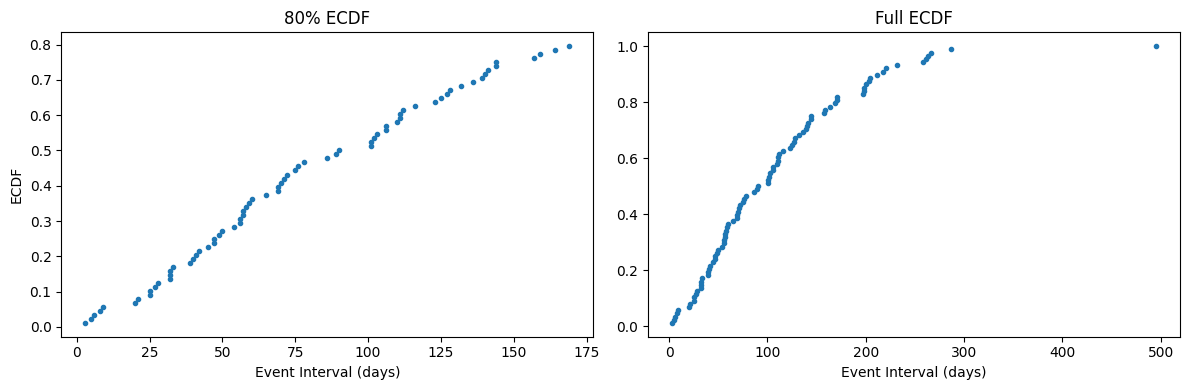

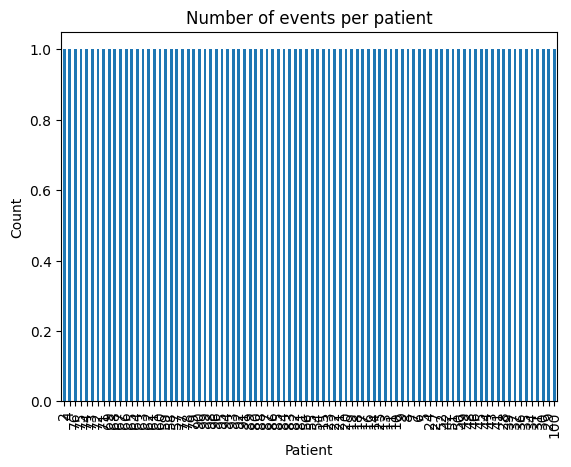

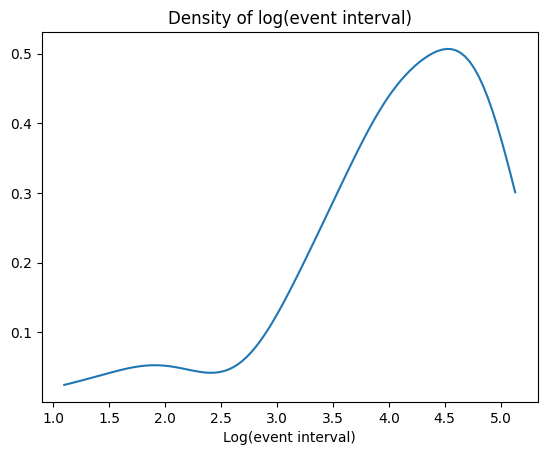

Optimal number of clusters (silhouette): 4


/var/folders/dg/1pp6958j3vxc6dcf5gfcx9g80000gn/T/ipykernel_18243/1794532596.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_work.groupby('pnr', group_keys=False).apply(lambda x: x.sample(1)).reset_index(drop=True)


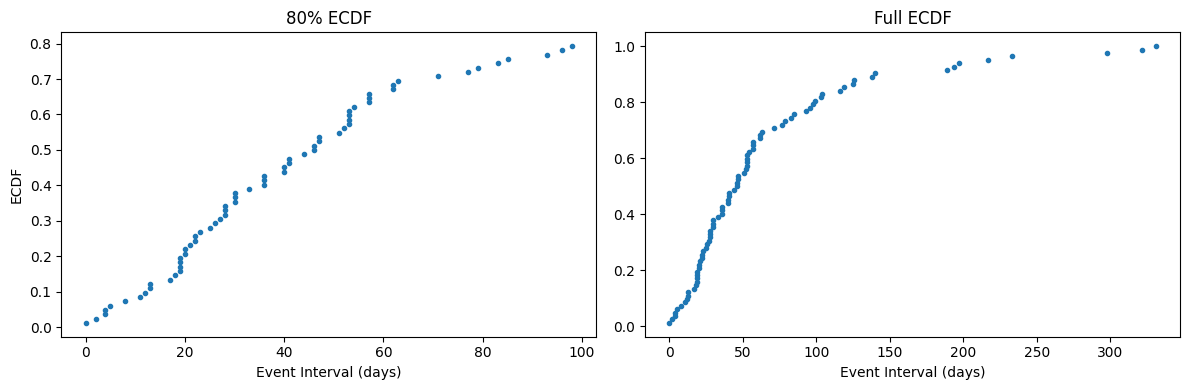

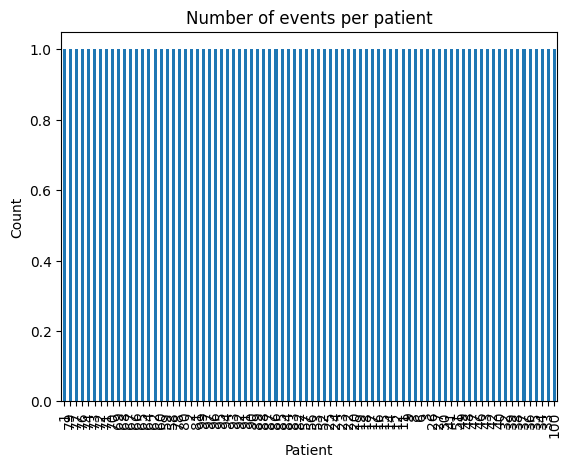

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


ValueError: array must not contain infs or NaNs

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from scipy.stats import gaussian_kde

# -------------------------------
# Data Preparation
# -------------------------------
# Read CSV using tab delimiter, because the file is tab-delimited.
tidy = pd.read_csv("data/med-events.csv", sep="\t")
# Rename columns to match the expected names
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
# Convert the date column using the format MM/DD/YYYY
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format="%m/%d/%Y", errors='coerce')
print("Data loaded with shape:", tidy.shape)
print(tidy.head())

# -------------------------------
# Function: See
# -------------------------------
def See(drug, df):
    """
    Replicates the SEE.R functionality:
    - Filters data for the specified drug (by ATC code)
    - Computes time intervals between consecutive prescriptions
    - Builds the empirical cumulative distribution function (ECDF)
      and removes the upper 20% to reduce outlier influence.
    - Performs density estimation on log-transformed intervals.
    - Determines the optimal number of clusters via silhouette analysis,
      then applies K-Means clustering.
    - Computes cluster-based summary statistics (min, max, median)
      and assigns an estimated prescription duration for each patient.
    
    Returns a DataFrame with the original drug data merged with the
    computed median duration and assigned cluster.
    """
    # Subset data for the specified drug
    subset = df[df['ATC'] == drug].copy()
    Drug_see_p0 = subset.copy()  # original subset
    
    # Sort by patient (pnr) and prescription date (eksd), then compute previous prescription date
    df_work = subset.sort_values(['pnr', 'eksd']).copy()
    df_work['prev_eksd'] = df_work.groupby('pnr')['eksd'].shift(1)
    df_work = df_work.dropna(subset=['prev_eksd'])
    
    # For each patient, randomly select one row to avoid overrepresentation
    df_sampled = df_work.groupby('pnr', group_keys=False).apply(lambda x: x.sample(1)).reset_index(drop=True)
    df_sampled = df_sampled[['pnr', 'eksd', 'prev_eksd']].copy()
    
    # Compute event interval (in days)
    df_sampled['event_interval'] = (df_sampled['eksd'] - df_sampled['prev_eksd']).dt.days
    
    # Compute empirical CDF for event intervals
    intervals = np.sort(df_sampled['event_interval'].values)
    cdf = np.arange(1, len(intervals) + 1) / len(intervals)
    df_ecdf = pd.DataFrame({'x': intervals, 'y': cdf})
    
    # Retain only the lower 80% of the ECDF (to remove outliers)
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    ni = df_ecdf_80['x'].max()  # cutoff threshold
    
    # Plot the 80% and full ECDF
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf_80['x'], df_ecdf_80['y'], marker='.', linestyle='none')
    plt.title("80% ECDF")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("ECDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(df_ecdf['x'], df_ecdf['y'], marker='.', linestyle='none')
    plt.title("Full ECDF")
    plt.xlabel("Event Interval (days)")
    plt.tight_layout()
    plt.show()
    
    # (Optional) Plot frequency of events per patient
    plt.figure()
    patient_counts = df_sampled['pnr'].value_counts()
    patient_counts.plot(kind='bar')
    plt.title("Number of events per patient")
    plt.xlabel("Patient")
    plt.ylabel("Count")
    plt.show()
    
    # Filter sampled data based on the ECDF threshold
    df_filtered = df_sampled[df_sampled['event_interval'] <= ni].copy()
    
    # Density estimation on log-transformed event intervals
    log_intervals = np.log(df_filtered['event_interval'])
    kde = gaussian_kde(log_intervals)
    x_dens = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_dens = kde(x_dens)
    plt.figure()
    plt.plot(x_dens, y_dens)
    plt.title("Density of log(event interval)")
    plt.xlabel("Log(event interval)")
    plt.show()
    
    # Determine optimal number of clusters using silhouette analysis on ECDF x-values
    X_for_cluster = df_ecdf['x'].values.reshape(-1, 1)
    sil_scores = {}
    for k in range(2, 7):
        kmeans = KMeans(n_clusters=k, random_state=1234).fit(X_for_cluster)
        labels = kmeans.labels_
        sil = silhouette_score(X_for_cluster, labels)
        sil_scores[k] = sil
    optimal_k = max(sil_scores, key=sil_scores.get)
    print("Optimal number of clusters (silhouette):", optimal_k)
    
    # Apply K-Means clustering on ECDF x-values
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=1234).fit(X_for_cluster)
    df_ecdf['cluster'] = kmeans_final.labels_
    
    # Compute cluster summary statistics (min, max, median) on x-values (using log transformation)
    cluster_stats = df_ecdf.groupby('cluster')['x'].agg(
        min_log=lambda vals: np.log(vals.min()),
        max_log=lambda vals: np.log(vals.max()),
        median_log=lambda vals: np.log(np.median(vals))
    ).reset_index()
    cluster_stats['Minimum'] = np.exp(cluster_stats['min_log'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max_log'])
    cluster_stats['Median'] = np.exp(cluster_stats['median_log'])
    cluster_stats = cluster_stats[['cluster', 'Minimum', 'Maximum', 'Median']]
    
    # Cross join the sampled data with cluster stats to assign clusters based on interval value
    df_cross = df_sampled.assign(key=1).merge(cluster_stats.assign(key=1), on='key').drop('key', axis=1)
    df_cross['Final_cluster'] = np.where(
        (df_cross['event_interval'] >= df_cross['Minimum']) &
        (df_cross['event_interval'] <= df_cross['Maximum']),
        df_cross['cluster'],
        np.nan
    )
    results = df_cross.dropna(subset=['Final_cluster']).copy()
    results['Final_cluster'] = results['Final_cluster'].astype(int)
    
    # For patients with multiple matches, take the most common cluster
    most_common_cluster = results['Final_cluster'].value_counts().idxmax()
    
    # Merge the results back to the sampled data, filling missing values with the median from the most common cluster
    df_sampled = df_sampled.merge(results[['pnr', 'Median', 'Final_cluster']], on='pnr', how='left')
    df_sampled['Median'] = df_sampled['Median'].fillna(
        cluster_stats.loc[cluster_stats['cluster'] == most_common_cluster, 'Median'].values[0]
    )
    df_sampled['Final_cluster'] = df_sampled['Final_cluster'].fillna(0).astype(int)
    df_sampled['test'] = np.round(df_sampled['event_interval'] - df_sampled['Median'], 1)
    
    # Merge the computed median and cluster assignments back to the original subset
    Drug_see_p3 = df_sampled[['pnr', 'Median', 'Final_cluster']].copy()
    final_result = Drug_see_p0.merge(Drug_see_p3, on='pnr', how='left')
    final_result['Median'] = pd.to_numeric(final_result['Median'], errors='coerce')
    final_result['Median'] = final_result['Median'].fillna(
        cluster_stats.loc[cluster_stats['cluster'] == most_common_cluster, 'Median'].values[0]
    )
    final_result['Final_cluster'] = final_result['Final_cluster'].fillna(0).astype(int)
    
    return final_result

# -------------------------------
# Function: see_assumption
# -------------------------------
def see_assumption(df):
    """
    Visualizes the refill durations (difference between consecutive prescription dates)
    by plotting them against the refill number.
    """
    df_assump = df.sort_values(['pnr', 'eksd']).copy()
    df_assump['prev_eksd'] = df_assump.groupby('pnr')['eksd'].shift(1)
    df_assump['p_number'] = df_assump.groupby('pnr').cumcount() + 1
    df_assump = df_assump[df_assump['p_number'] >= 2].copy()
    df_assump = df_assump[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    df_assump['Duration'] = (df_assump['eksd'] - df_assump['prev_eksd']).dt.days
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='p_number', y='Duration', data=df_assump)
    plt.title("Boxplot of Duration by Refill Number")
    plt.xlabel("Refill Number")
    plt.ylabel("Duration (days)")
    
    medians_of_medians = df_assump.groupby('pnr')['Duration'].median().median()
    plt.axhline(y=medians_of_medians, color='red', linestyle='--',
                label=f'Median of medians: {medians_of_medians:.1f}')
    plt.legend()
    plt.show()
    
    return plt.gca()

# -------------------------------
# Example usage:
# -------------------------------
# Compute SEE for two drugs ("medA" and "medB")
medA = See("medA", tidy)
medB = See("medB", tidy)

# Visualize the assumption plots for medA and medB
see_assumption(medA)
see_assumption(medB)
